In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, h5py, gc, numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
import concurrent.futures as cf
from pathlib import Path
from torch.utils.data import DataLoader

REPO_ROOT = "../"
proj = Path(REPO_ROOT).resolve()

# allow: import ADCNN.*
sys.path.insert(0, str(proj))

# allow: import utils.*  (where utils == ADCNN/utils)
sys.path.insert(0, str(proj / "ADCNN"))

import experiments.exp_utils.postprocess as postprocess
from ADCNN.data.h5tiles import H5TiledDataset
from ADCNN.predict import load_model, predict_tiles_to_full
import ADCNN.evals.basic_evals as evals
import ADCNN.evals.threshold_scan as threshold_scan

test_h5 = "../DATA/test.h5"
test_csv = "../DATA/test.csv"
MODEL_CKPT = "../checkpoints/Best/ckpt_best.pt"
SAVE_PATH = "../checkpoints/Experiments/"

In [2]:
def calculate_model_metrics (catalog, predictions, ground_truth, thr_points=100, stack_fp=None, best_threshold=None):
    catalog = catalog.copy()
    threshold_df = threshold_scan.scan_thresholds(catalog=catalog, predictions=predictions, ground_truth=ground_truth, stack_fp=stack_fp, n_points=thr_points)
    threshold_scan.plot_fscore(threshold_df["thr"], pix_f1=threshold_df.get("pix_f1"), pix_f2=threshold_df.get("pix_f2"),
                               obj_f1=threshold_df.get("obj_f1"), obj_f2=threshold_df.get("obj_f2"), title="Pixelwise vs Objectwise F-scores")
    threshold_scan.plot_roc(threshold_scan.compute_roc(threshold_df["pix_tp"], threshold_df["pix_fp"], threshold_df["pix_tn"], threshold_df["pix_fn"]))
    threshold_scan.plot_froc(threshold_scan.compute_froc(thr=threshold_df["thr"], obj_tp=threshold_df["obj_tp"], obj_fp=threshold_df["obj_fp"], obj_fn=threshold_df["obj_fn"], n_images=50),
                             title="FROC (objectwise)")
    if best_threshold is None:
        best_threshold = threshold_df["thr"][threshold_df["obj_f2"].argmax()]
    _,_,catalog = evals.confusion_matrix(catalog=catalog, ground_truth= ground_truth,predictions=predictions, stack_fp=stack_fp, threshold=best_threshold, verbose=True)
    _ = evals.plot_detect_hist(catalog, "PSF_mag", bins=12, title="NN detections vs PSF_mag threshold=" + str(round(best_threshold, 3)))
    _ = evals.plot_detect_hist(catalog, "trail_length", bins=12, title="Detections vs trail length threshold="+ str(round(best_threshold, 3)))
    _ = evals.plot_detect_hist(catalog, "SNR", bins=10, title="Detections vs SNR threshold="+ str(round(best_threshold, 3)), xlim=[0, 10], density=True)
    plt.show()
    return catalog

In [3]:
ds_te = H5TiledDataset(test_h5,  tile=128, k_sigma=5.0)

test_loader = DataLoader(
    ds_te,
    batch_size=128,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
    persistent_workers=False,
    prefetch_factor=None,
)

test_catalog = pd.read_csv(test_csv)
with h5py.File(test_h5, "r") as _f:
    gt_test = _f["masks"][:].astype(np.uint8)
    stack_fp = _f["real_labels"][:].astype(np.uint16)
print("Test tiles:", len(ds_te))

Test tiles: 51200


Loaded model from: ../checkpoints/Experiments/Last/idea8.pt
Predictions shape: (50, 4000, 4072)


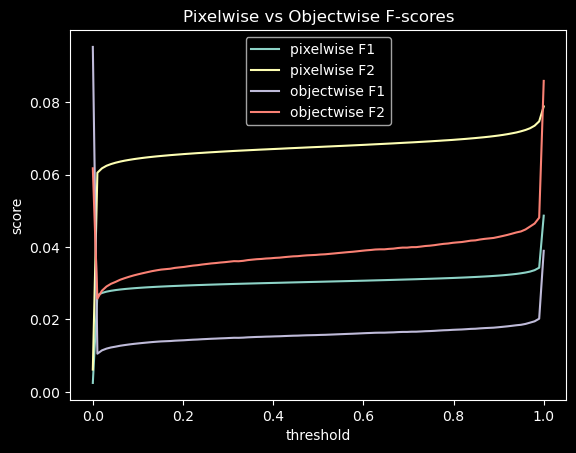

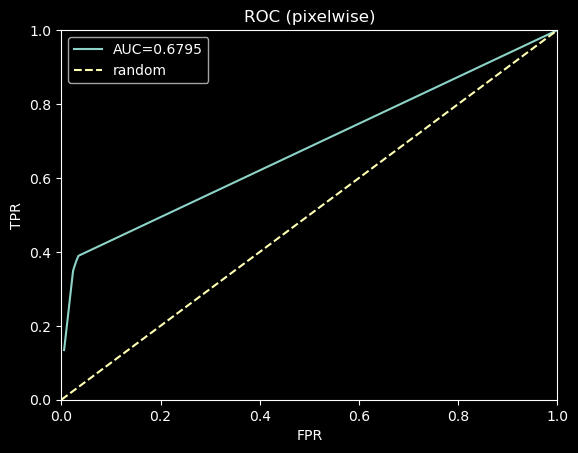

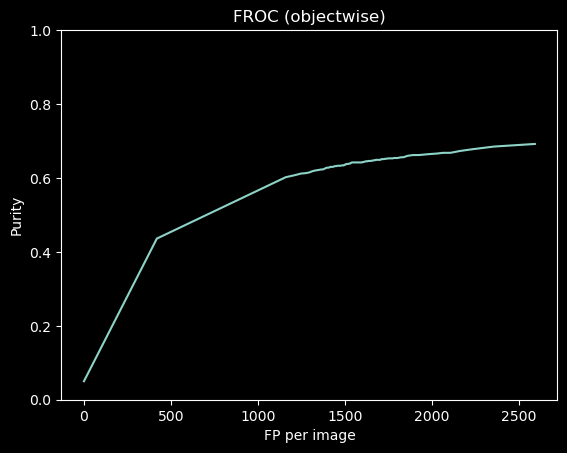

Pixel-wise Confusion Matrix
F1 Score: 0.0486, F2 Score: 0.0788
                 Predicted Negative  Predicted Positive
Actual Negative           808971378             4421228
Actual Positive              872060              135334

Object-wise Confusion Matrix
F1 Score: 0.0391, F2 Score: 0.0862
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>               20862
Actual Positive                 564                 436



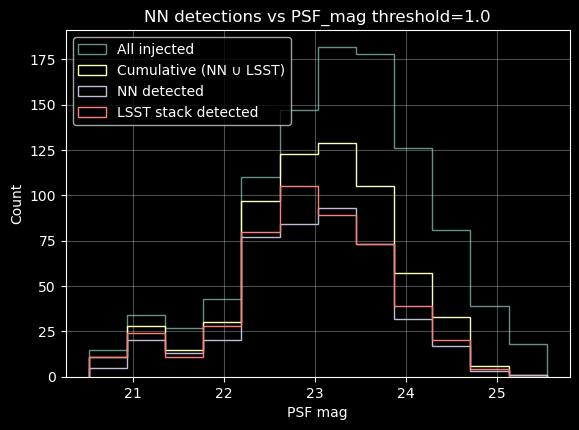

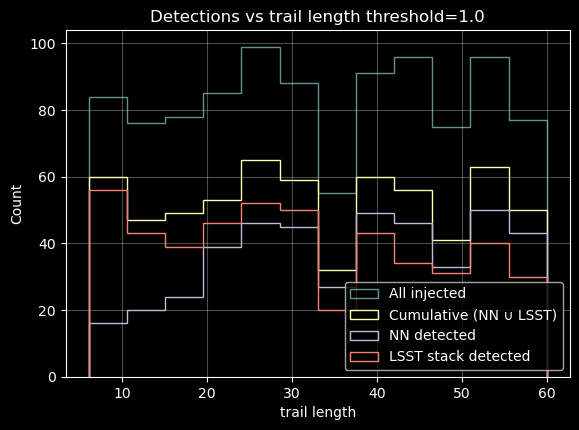

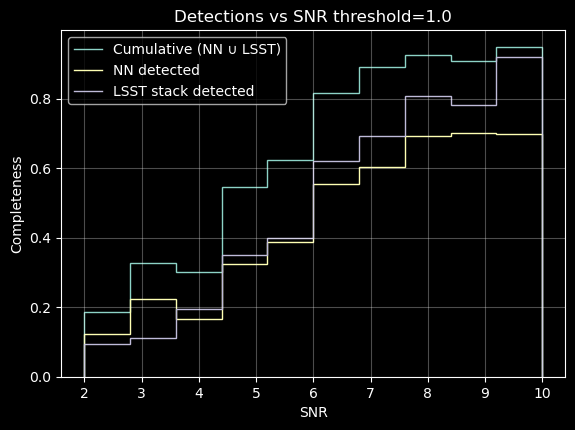

In [5]:
model_8 = load_model(SAVE_PATH+"Last/idea8.pt")
p_8 = predict_tiles_to_full(test_h5, test_loader, model_8, tile=128)
model_8.to('cpu')
gc.collect()
torch.cuda.empty_cache()
print("Predictions shape:", p_8.shape)
__ = calculate_model_metrics(test_catalog, p_8, gt_test, stack_fp=stack_fp)

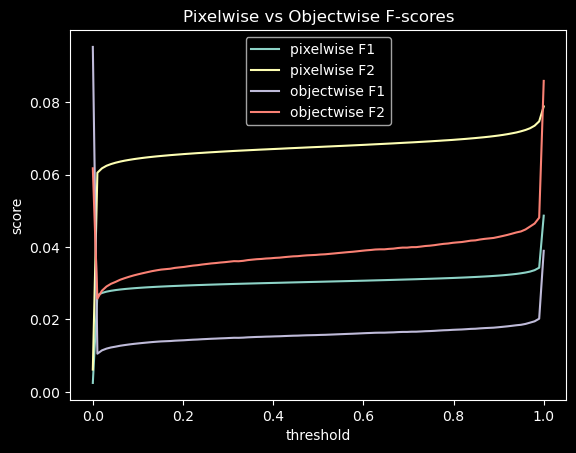

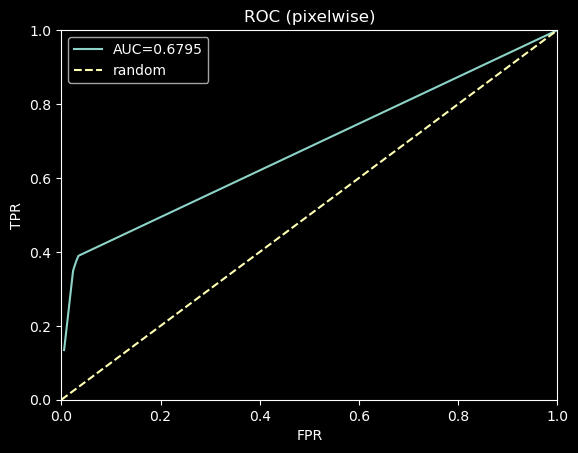

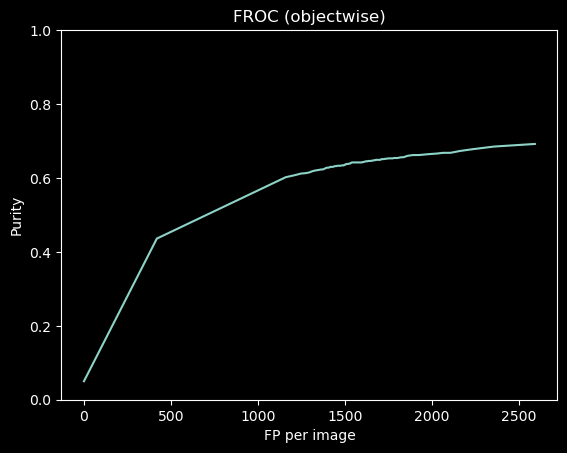

Pixel-wise Confusion Matrix
F1 Score: 0.0304, F2 Score: 0.0676
                 Predicted Negative  Predicted Positive
Actual Negative           790306996            23085610
Actual Positive              635658              371736

Object-wise Confusion Matrix
F1 Score: 0.0157, F2 Score: 0.0379
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>               80182
Actual Positive                 357                 643



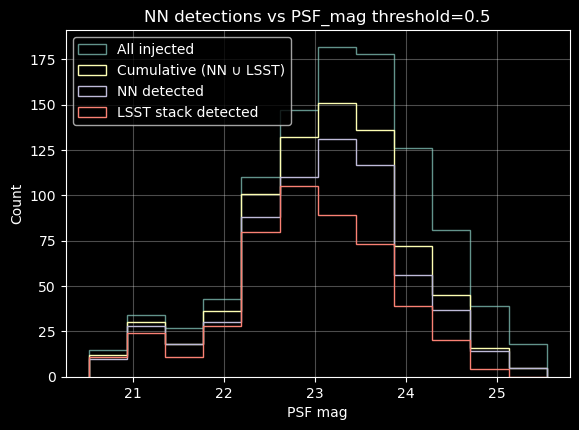

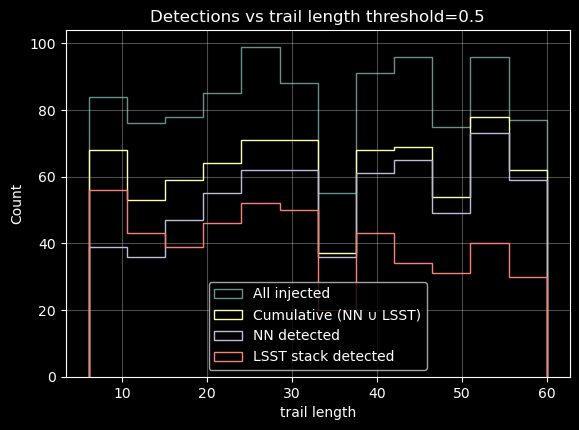

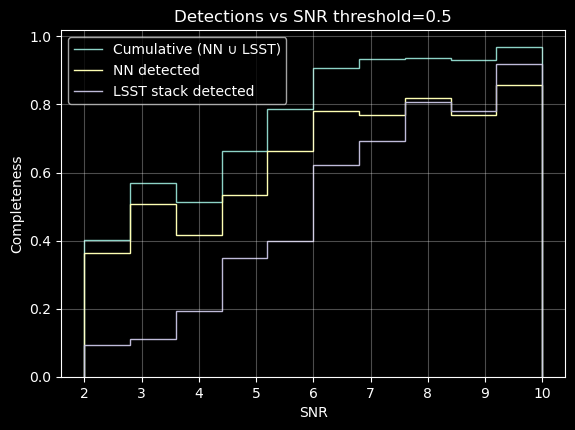

In [6]:
__ = calculate_model_metrics(test_catalog, p_8, gt_test, stack_fp=stack_fp, best_threshold=0.5)

In [7]:
p_8_tt = postprocess.two_threshold_prediction(p_8, t_low=0.07, pixel_gap=1)

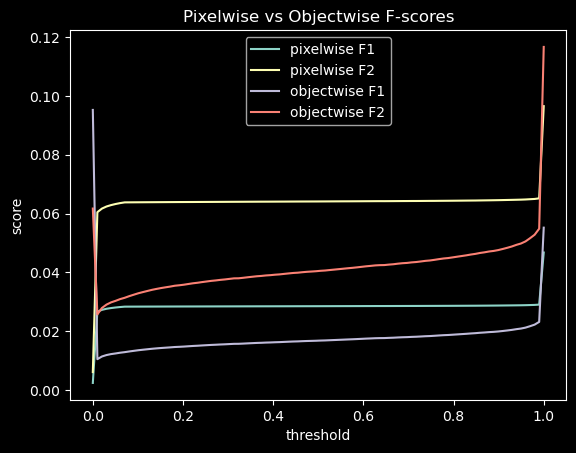

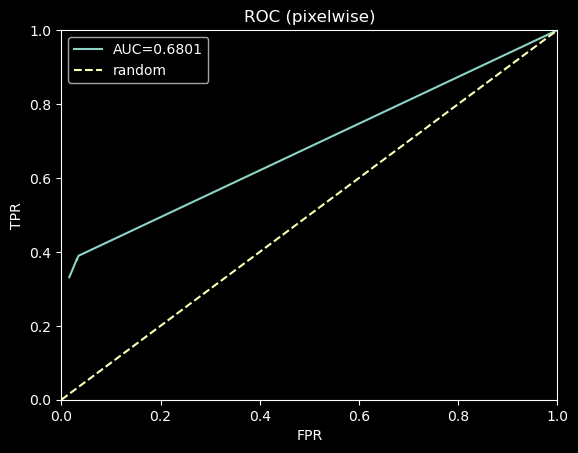

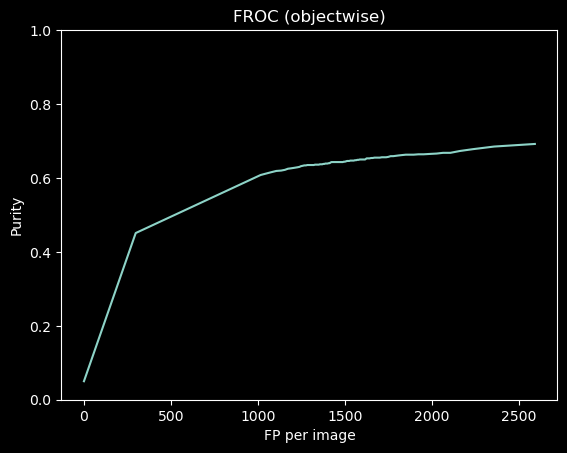

Pixel-wise Confusion Matrix
F1 Score: 0.0468, F2 Score: 0.0965
                 Predicted Negative  Predicted Positive
Actual Negative           800464420            12928186
Actual Positive              673596              333798

Object-wise Confusion Matrix
F1 Score: 0.0553, F2 Score: 0.1167
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>               14874
Actual Positive                 549                 451



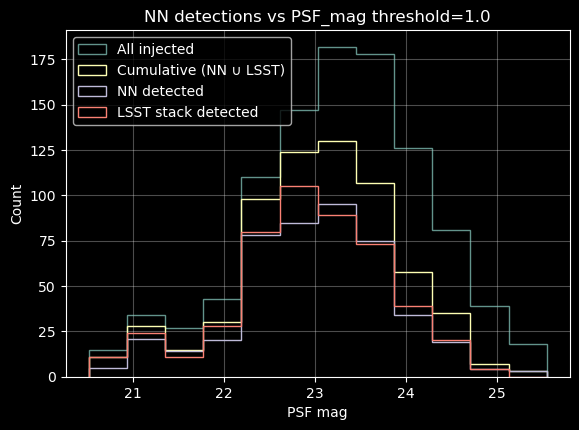

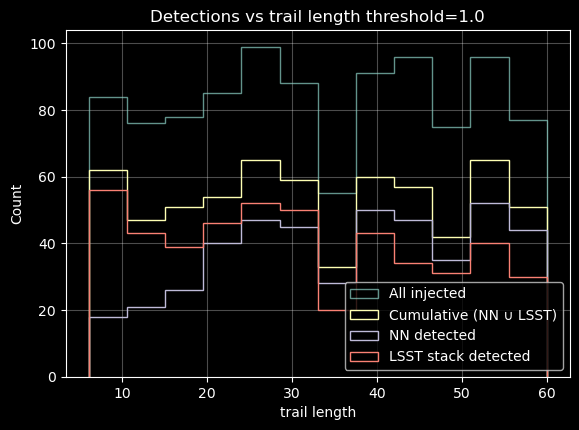

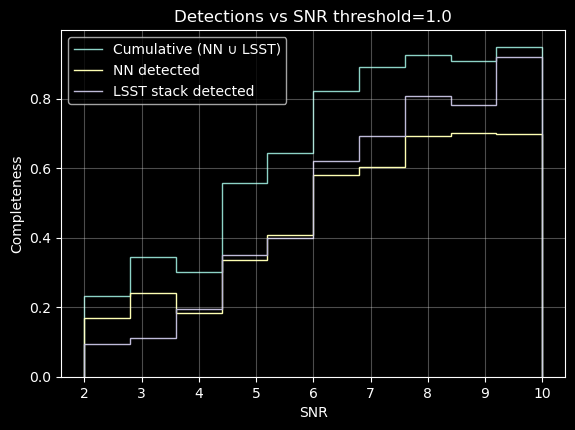

In [8]:
__ = calculate_model_metrics(test_catalog, p_8_tt, gt_test, stack_fp=stack_fp)

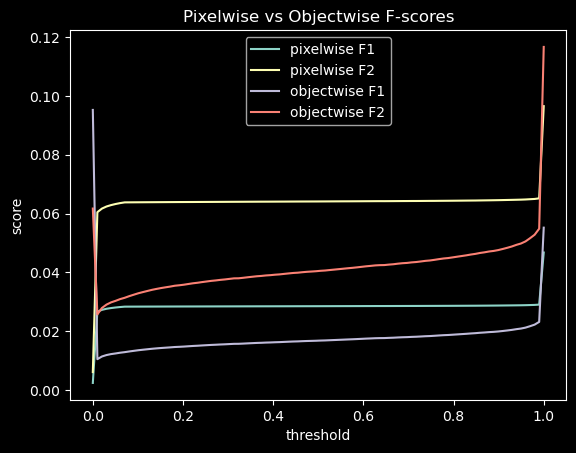

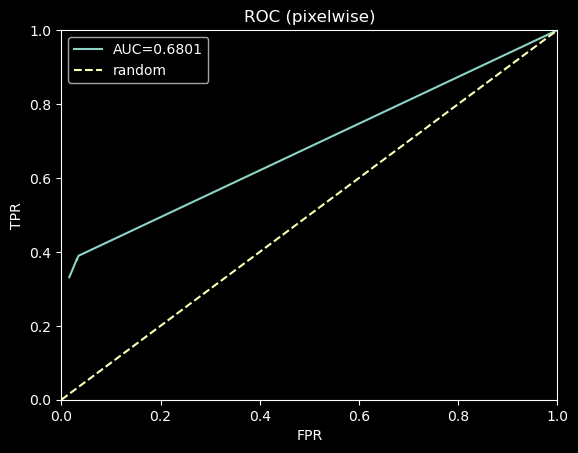

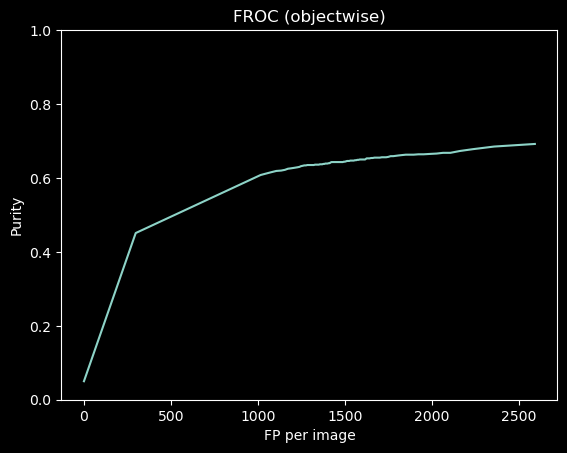

Pixel-wise Confusion Matrix
F1 Score: 0.0285, F2 Score: 0.0641
                 Predicted Negative  Predicted Positive
Actual Negative           787966157            25426449
Actual Positive              624648              382746

Object-wise Confusion Matrix
F1 Score: 0.0168, F2 Score: 0.0405
                 Predicted Negative  Predicted Positive
Actual Negative                <NA>               74806
Actual Positive                 356                 644



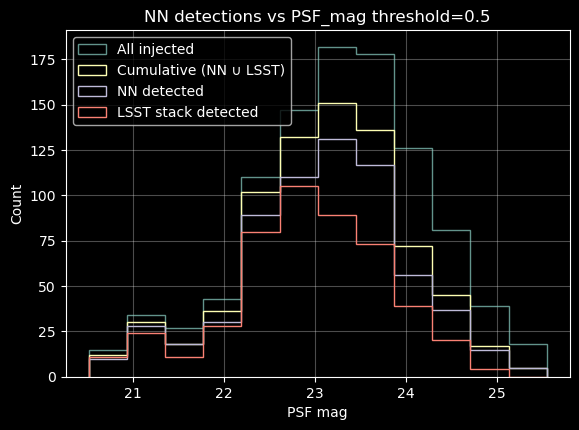

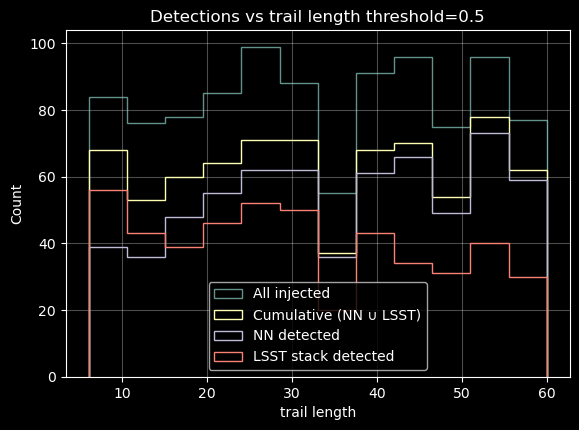

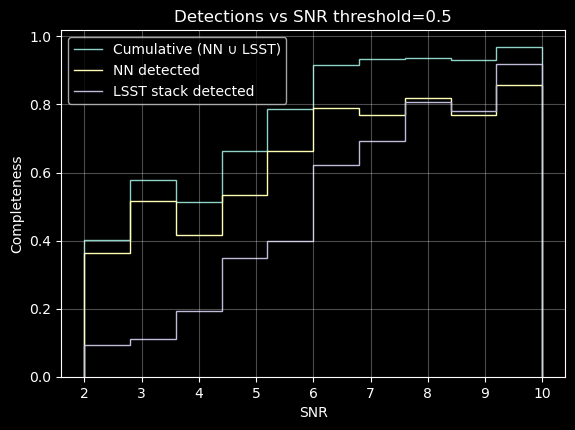

In [9]:
__ = calculate_model_metrics(test_catalog, p_8_tt, gt_test, stack_fp=stack_fp, best_threshold=0.5)

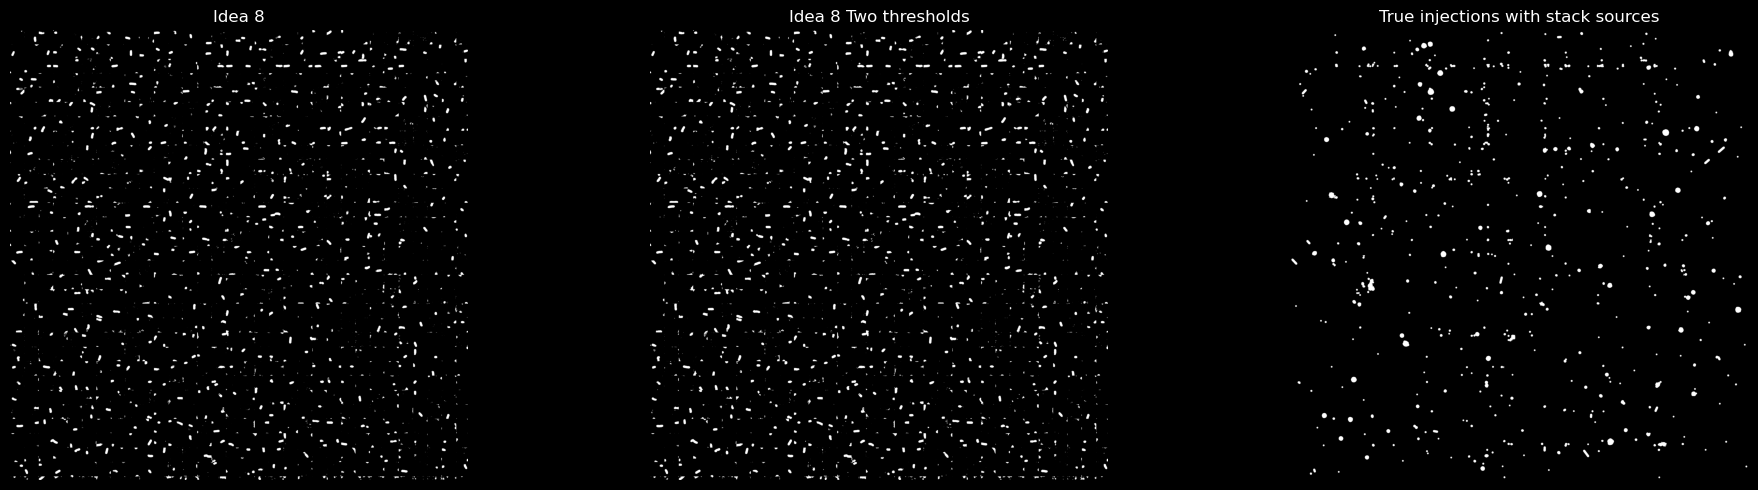

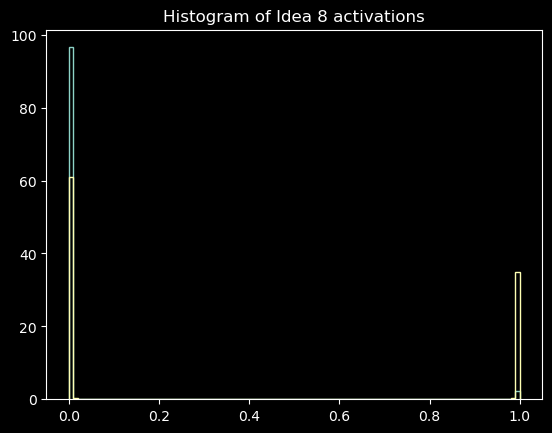

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(p_8[0], cmap='gray', vmin=0, vmax=1)
ax[0].axis('off')
ax[0].set_title("Idea 8")
ax[1].imshow(p_8_tt[0], cmap='gray', vmin=0, vmax=1)
ax[1].axis('off')
ax[1].set_title("Idea 8 Two thresholds")
ax[2].imshow((gt_test[0] | (stack_fp[0] > 0.5)), cmap='gray', vmin=0, vmax=1)
ax[2].axis('off')
ax[2].set_title("True injections with stack sources")
fig.tight_layout()
plt.show()
plt.hist(p_8[gt_test<0.5].flatten(), density=True, bins=100, histtype='step')
plt.hist(p_8[gt_test>0.5].flatten(), density=True, bins=100, histtype='step')
plt.title("Histogram of Idea 8 activations")
plt.show()